In [1]:
Names = 'Titus Jungao and Jude Teves'

In [2]:
from sklearn.neighbors import KNeighborsRegressor

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
df_bikesharing = pd.read_excel('Bike_Sharing_day.xlsx', sheetname="day")
dummy=df_bikesharing
dummy.head()

C:\Anaconda\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,count
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [112]:
dummy.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
count         0
dtype: int64

Bike Sharing dataset

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df_features=dummy.drop('count', axis=1)
df_features=df_features.drop('instant', axis=1)
df_features=df_features.drop('dteday', axis=1)
len(df_features)
df_features.head(5)

X = df_features
y = dummy['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

y_train = np.array(y_train, ndmin=2).T
y_test = np.array(y_test, ndmin=2).T

scalerX = StandardScaler()
scalerY = StandardScaler()
# scalerX = MinMaxScaler()
# scalerY = MinMaxScaler()

X_train = scalerX.fit_transform(X_train)
y_train = scalerY.fit_transform(y_train)

X_test = scalerX.transform(X_test)
y_test = scalerY.transform(y_test)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Implement NN

In [268]:
from sklearn.metrics import r2_score

class NN():
    
    def __init__(self, layers, activations, gamma):
        self.layers = layers
        self.activations = activations
        self.gamma = gamma
        self.cache = {}
        
        np.random.seed(42)
        self.weights = {}
        w = 0.001
        #w = 1
        for i in range(1,len(self.layers)):
            self.weights['w'+str(i)] = w*(2*np.random.random((self.layers[i], self.layers[i-1]))-1)
             
    def forward_propagation(self, X):
        self.cache = {}
        layer_curr = X.T
        self.cache['a0'] = layer_curr
        
        for i in range(1, len(self.layers)):
            layer_pre = self.weights['w'+str(i)].dot(layer_curr)
            self.cache['a'+str(i)] = layer_pre
            layer_curr = self.activations[i](layer_pre)
            
        #print('Forward prop final shape: ', layer_curr.shape)
        return layer_curr
    
    def backward_propagation(self, error):
        layer_error = error
        #print(layer_error.shape)
        for i in range(1, len(self.layers))[::-1]:
            #print(self.activations[i-1])
            layer_curr = self.cache['a'+str(i)]
            layer_pre = self.cache['a'+str(i-1)]
#             print(layer_pre.shape)
            if i != len(self.layers)-1:
                layer_error = self.weights['w'+str(i+1)].T.dot(layer_error)
            layer_error = layer_error*self.activations[i](layer_curr, deriv=True)
            self.weights['w'+str(i)] -= self.gamma * layer_error.dot(self.activations[i-1](layer_pre.T))
            
    def compute(self, X, y, X_test, y_test, iterations):
        y = y.reshape(1, -1)
        y_test = y_test.reshape(1, -1)
        
        error_history = []
        error_history_test = []
        accs_train = []
        accs_test = []
        
        for i in range(iterations):
#             if i>4340:
#                 print(y_pred)
            
            #test
            y_pred = self.forward_propagation(X_test)
            y_pred = y_pred.reshape(1, -1)
            error = y_pred - y_test
            error_history_test.append(np.mean(abs(error), axis=1))
            
            #test accuracy
            acc = max(0,r2_score(y_pred.flatten(), y_test.flatten()))
            accs_test.append(acc)

            #train
            y_pred = self.forward_propagation(X)
            y_pred = y_pred.reshape(1, -1)
            #print(y_pred)
            error = y_pred - y
            error_history.append(np.mean(abs(error), axis=1))
            
            #train accuracy
            acc = max(0,r2_score(y_pred.flatten(), y.flatten()))
            accs_train.append(acc)
            
            self.backward_propagation(error)
        
        return error_history, error_history_test, accs_train, accs_test

In [269]:
class Activation():
    def get(self, type):
        if type == 'linear':
              return self.linear
        elif type == 'sigmoid':
              return self.sigmoid
        elif type == 'sine':
              return self.sine
        elif type == 'tanh':
              return self.tanh
        elif type == 'relu':
              return self.relu
            
    @staticmethod
    def linear(x, deriv=False):
        if(deriv==True):
            return 1
        return x
            
    @staticmethod
    def sigmoid(x, deriv=False):
        sigmoid = 1/(1+np.exp(-x))
        if(deriv==True):
            return sigmoid*(1-sigmoid)
        return sigmoid
    
    @staticmethod
    def sine(x, deriv=False):
        if(deriv==True):
            return np.cos(x)
        return np.sin(x)
    
    @staticmethod
    def tanh(x, deriv=False):
        if(deriv==True):
            return 1-np.tanh(x)**2
        return np.tanh(x)
    
    @staticmethod
    def relu(x, deriv=False):
        if(deriv==True):
            return x>0
        return x*(x>0)

In [270]:
# Activation().get('sigmoid')(X)

In [271]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((548, 11), (548, 1), (183, 11), (183, 1))

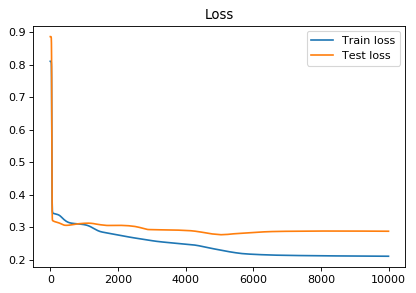

Max test accuracy: 90.46% | Epoch: 5362


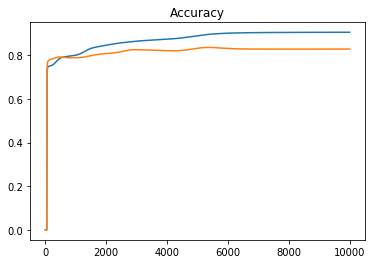

In [275]:
act = Activation()
# first activation must be linear
# activations = [act.get('sine'),act.get('sigmoid')]
activations = [act.get('linear'),act.get('sigmoid'),act.get('linear')]
# activations = [act.get('sine'),act.get('sigmoid'),act.get('linear')]
# activations = [act.get('sine'),act.get('sigmoid'),act.get('sine'),act.get('linear')]
# activations = [act.get('linear'),act.get('relu'),act.get('relu'),act.get('linear')]

# first hidden layer is a buffer layer.
# nn = NN((18,10,1),activations,0.001)
nn = NN((11,6,1),activations,0.001)
# nn = NN((11,6,6,1),activations,0.001)

error_hist, error_hist_test, accs_train, accs_test = nn.compute(X_train, y_train, X_test, y_test, 10000)

plt.figure(dpi=80)
plt.plot(error_hist, label='Train loss')
plt.plot(error_hist_test, label='Test loss')
plt.legend()
plt.title('Loss')
plt.show()

print('Max test accuracy: {:.2%} | Epoch: {}'.format(max(accs_train), np.argmax(accs_test)))
plt.plot(accs_train, label='Train accuracy')
plt.plot(accs_test, label='Test accuracy')
plt.title('Accuracy')
plt.show()


## Using Traditional ML techniques